# Pre Simulation Testing

Now that we have created our input file we need to verify that our simulation parameters will give a good simulation.

In [1]:
# Import the usual libraries
%pylab
%matplotlib inline
import os

plt.style.use('MSUstyle')

# Import sarkas
from sarkas.processes import Simulation, PostProcess, PreProcess

# Create the file path to the YAML input file
input_file_name = os.path.join('tutorial_yaml_files', 'yukawa_mks_p3m.yaml')

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Simulation Parameters

Let's verify that our input parameters

In [2]:
preproc = PreProcess(input_file_name)
preproc.setup(read_yaml=True)










 _______  _______  _______  _        _______  _______ 
(  ____ \(  ___  )(  ____ )| \    /\(  ___  )(  ____ \
| (    \/| (   ) || (    )||  \  / /| (   ) || (    \/
| (_____ | (___) || (____)||  (_/ / | (___) || (_____ 
(_____  )|  ___  ||     __)|   _ (  |  ___  |(_____  )
      ) || (   ) || (\ (   |  ( \ \ | (   ) |      ) |
/\____) || )   ( || ) \ \__|  /  \ \| )   ( |/\____) |
\_______)|/     \||/   \__/|_/    \/|/     \|\_______)
                                                      


An open-source pure-python molecular dynamics code for non-ideal plasmas.



======================= Simulation ==========================

Job ID:  yocp
Job directory:  Simulations/yocp_pppm
Equilibration dumps directory:  Simulations/yocp_pppm/Equilibration/dumps
Production dumps directory:  Simulations/yocp_pppm/Production/dumps

Units:  mks
Total No. of particles =  10000

Particle Species:
No. of species =  1
Species 1 : H
	Species ID: 0
	No. of particles = 10000 
	Number density = 1.

As you can see the output is rather verbose, so let's unpack it.

### Sarkas Figlet
The first screen output is the Sarkas Figlet. This is printed at the beginning of every `sarkas.processes` by the static method `screen_figlet()` of the `InputOutput` class. The Figlet font and colors are chosen randomly from a predefined set in `sarkas.utilities.io`. This function assumes a white background if you are running a Jupyter notebook, while a dark background in the case of an IPython/Python kernel.

### Warnings
Right after the Sarkas Figlet warnings regarding inputs from the YAML file will be printed. In this case we did not define the equilibration temperatures in the `Thermostat` section of the YAML file. Another possible warnings is too large of a cut-off radius for the potential.

### Simulation
Next we have the `Simulation` section where all simulation parameters are printed. These include inputs from the YAML file and calculated constants. For example, we find the value of the Wigner-Seitz radius, ``a_ws``, the number of non zero dimensions, and the length of the simulation box sides in terms of ``a_ws`` and its numerical value in the chosen units. 

Few lines below we find Potential info. Note that this section depends on the type of potential and as such it varies. Next we find the Algorithm section. This is particularly verbose in the case of the PPPM algorithm since we have parameters for the PP and PM part of the algorithm. We will come back to this number later in the discussion

### Initialization Times
In this section are indicated the times for the initialization part of the simulation. These times are

- `Potential Initialization` where the all the potential parameters, including the Optimal Green's function in the case of PPPM algorithm, are calculated.
- `Particles Initialization` where the particles positions and velocities are initialized. This includes the case where a specific particles distribution is chosen.

## Time Estimates

The above output is intended to be a check on the choice of parameters. The `PreProcess` class provides also an estimate of the various phases of a simulation. The times are estimated by running several step of the simulation and average over them. This is done by the method `run()` of the `PreProcess` class. 

In [3]:
preproc.run(
    timing=True, # time estimation, default is True
    loops = 10,   # the number of timesteps to average, Default is 10
           )
# Note that the argument `loops` should be chosen to be larger than `production_dump_step`
# in order to get a more accurate estimate. 



====================== Times Estimates ===========================

Optimal Green's Function Time: 
0 min 0 sec 4 msec 18 usec 2 nsec 

Time of PP acceleration calculation averaged over 10 steps: 
0 min 0 sec 190 msec 545 usec 232 nsec 

Time of PM acceleration calculation averaged over 10 steps: 
0 min 0 sec 269 msec 534 usec 64 nsec 


Running 10 equilibration and production steps to estimate simulation times




Time of a single equilibration step averaged over 10 steps: 
0 min 0 sec 295 msec 394 usec 48 nsec 




Time of a single production step averaged over 10 steps: 
0 min 0 sec 249 msec 424 usec 853 nsec 



----------------- Total Estimated Times -----------------------

Equilibration Time: 0 hrs 4 min 55 sec

Production Time: 0 hrs 20 min 47 sec

Total Run Time: 0 hrs 25 min 42 sec


The first part of the output shows the times needed for the force calculation and the averaged time for an equilibration and production time step. 

As you can see the calculation of the optimal Green's function takes a relatively long time. Fortunately this needs be calculated once at the beginning of the simulation. We note also that the PM part takes ~1.5x the time it takes for the PP part. This is specific to this hardware and the opposite case could be true on other machines.

Next Sarkas will run `loops` timesteps for each phase to estimate the time of each. These are indicated by the
green bars, a nice feature from the ``tqdm`` package. Below the green bars we find the average time of each phase. Note that the equilibration phase takes longer than the production phase. This is due to the presence of athermostat.

At the end all the estimates are put together to calculate the equilibration, production, and total run times.

The Equilibration and Production times are then calculated by multiplying the above times by `equilibration_steps` and `production_steps`, respectively. 

>**_NOTE:_**  These times will vary depending on the computer hardware. For this tutorial we used a 2019 Dell XPS 8930 with Intel Core i7-8700K @ 3.70Ghz and 48GB of RAM running Ubuntu 18.04.


## Force Error
As promised we return now to the explanation of the parameters in the Algorithm section of the Simulation output. 

The two important parameters in this section are: the Ewald parameter $\alpha$ and the cutoff radius, $r_c$. Below the line ``Mesh = [64 64 64]`` the number of cells per dimension for the Linked Cell algorithm and the number of particles inside a spheres of radius $r_c$. Next we find the most important information: the error in the force calculation. This is the error incurred when we cut the potential interaction after a certain distance. For more details on the way this is calculated see the page [Force Error](../theory/force_error.html). This number is dimensionless since all the variable have been rescaled. 
There is no _good_ value for the Force error and it is up to the user to decide. In Non-Ideal plasmas it is usually chosen to be less than ``1e-5``. In this case we have `Tot Force Error = 5.195766e-06`. 

The method `pppm_approximation()` of the `PreProcess` class calculates estimates of `Tot Force Error` for several $r_c$ and $\alpha$ parameters. This time the output will be two figures. These two figures are meant to help the user find the optimal PPPM parameters. 

Note that the same plots can be obtained by choosing `pppm_plots=True` as an argument in `run()`.

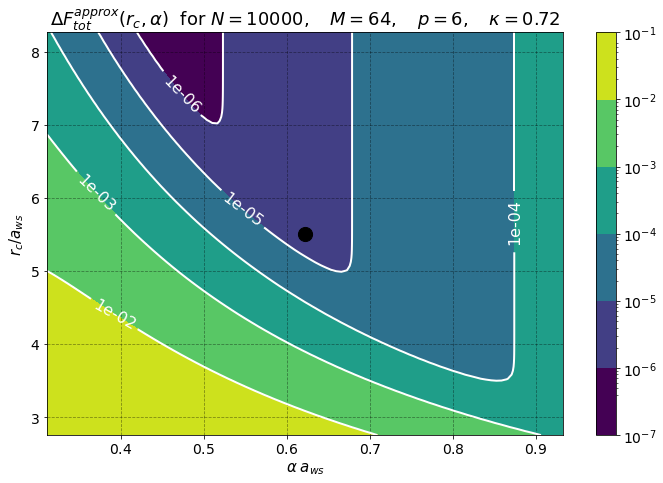

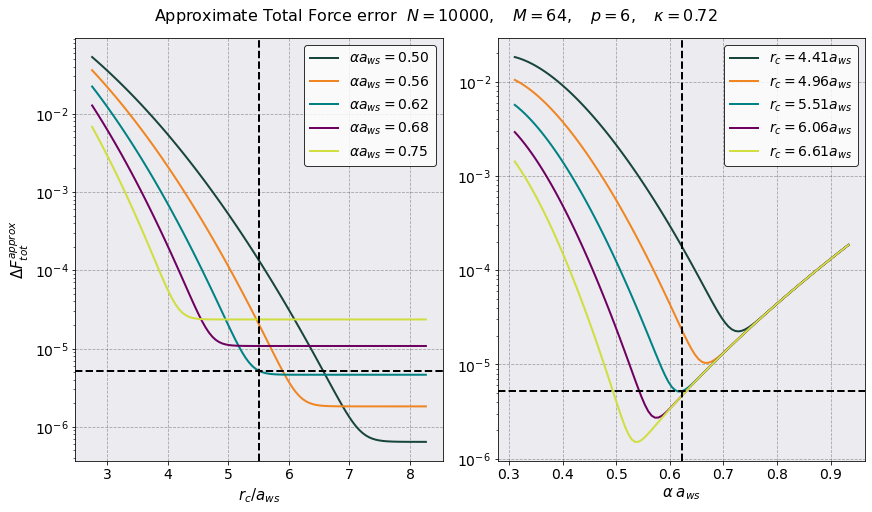

In [4]:
preproc.pppm_approximation()

The first figure is a contour map in the $(r_c,\alpha)$ parameters space of 

$$ \Delta F_{\textrm{tot}}^{(\textrm{approx})}( r_c, \alpha) = \sqrt{ \Delta F_{\rm PP}^2 +
            ( \Delta F_{\rm PM}^{(\textrm{approx})} ) ^2 } $$
            
where $\Delta F_{\rm PP}$ is the ``PP Force Error``. $\Delta F_{\rm PM}^{(\textrm{approx})}$ is calculated from an approximation of the PM force error, hence the superscript $\rm approx$, and its functional form is different than the one calculated in ``PM Force Error``. See [Force Error](../theory/force_error.rst) for more detail. The numbers on the white contours indicate the value of $\Delta F_{\textrm{tot}}^{(\textrm{apprx})}$ along those lines and the black dot indicates our choice of parameters. Notice that our parameter choice falls in the region in between ``1e-5`` and ``1e-6`` as expected, recall `Tot Force Error = 5.195766e-06`.
Furthermore, this plot tells us that if we want a force error of the order 1e-6 we need
to choose values that fall into the small purple triangle at the top.

However, our choice of parameters while being good, it might not be optimal. In order to find the best choice we look at the second figure.

The left panel is a plot of $\Delta F_{\textrm{tot}}^{(\textrm{approx})}$ vs $r_c/a_{\rm ws}$ at
five different values of $\alpha a_{\rm ws}$ while the right panel is a plot of
$\Delta F_{\textrm{tot}}^{(\textrm{approx})}$ vs $\alpha a_{\rm ws}$ at five different values of $r_c/a_{\rm ws}$. The vertical black dashed lines indicate our choice of $\alpha a_{\rm ws}$ and $r_c/a_{\rm ws}$. The horizontal black dashed lines, instead, indicate the value `Tot Force Error = 5.195766e-06`.

These plots show that our analytical approximation is a very good approximation and that our choice of parameters is optimal as the intersection of the dashed lines falls exactly in the minimum of the curves. From the left panel we find that larger values for $r_c = 5.51$ lead to an inefficient code since we will be calculating the interaction for many more particles without actually reducing the force error. Similarly, the right panel shows that our choice of $r_c$ is close to optimal given $\alpha a_{ws} = 0.614$.

Some good rules of thumb to keep in mind while choosing the parameters are

- larger (smaller) $\alpha$ lead to a smaller (larger) PM error, but to a larger (smaller) PP error,
- larger (smaller) $r_c$ lead to a smaller (greater) PP part but do not affect the PM error,
- keep an eye on the PM and PP calculation times.
- larger $r_c$ lead to a longer time spent in calculating the PP part of the force since there are more neighbors,
- larger or smaller $\alpha$ do not affect the PM calculation time since this depends on the number of mesh points,
- choose the number of mesh points to be a power of 2 since FFT algorithms are most efficient in this case.

>**_NOTE:_**  The above investigation is useful in choosing the parameters $r_c$ and $\alpha$ for fixed values of the charge approximation order, $p$, the number of mesh points, $M_x = M_y = M_z$, and number of aliases $m_x = m_y = m_z$.


## Post Processing

All the above information are needed in order to run a simulation and produce data to be analyzed in the post-processing phase. However, the optimal choice of the above parameters does not necessarily indicate that our desired physical observable is calculated correctly. Thus, we need to verify that our choices lead to the desired physical result.

By setting `postprocessing=True` as the argument of `run()` we will print the parameters of the physical observables that we decided to calculate in the `PostProcessing` section of the YAML file. 

In [5]:
preproc.run(timing=False, postprocessing=True)



===================== Post Processing ============================

Radial Distribution Function:
No. bins = 500
dr = 0.0110 a_ws = 1.2540e-13 [m]
Maximum Distance (i.e. potential.rc)= 5.5100 a_ws = 6.2702e-11 [m]

Static Structure Factor:
No. of ka harmonics = n_x, n_y, n_z = 10, 10, 10
No. of ka values to calculate = 1330
Smallest wavevector k_min = 3.9 / N^(1/3)
k_min = 0.1809 / a_ws = 2.5303e+09 [1/m]
Largest wavevector k_max = k_min * sqrt( n_x^2 + n_y^2 + n_z^2)
k_max = 3.1336 / a_ws = 4.3826e+10 [1/m]

Dynamic Structure Factor:
Frequency Constants
	No. of slices = 1
	No. steps per slice = 2500
	No. dumps per slice = 1250
	Frequency step dw = 2 pi (no_slices * prod_dump_step)/(production_steps * dt)
	dw = 0.0246 w_p = 4.1289e+14 [Hz]
	Maximum Frequency w_max = 2 pi /(prod_dump_step * dt)
	w_max = 15.4018 w_p = 2.5806e+17 [Hz]
Wavevector Constants
	No. of ka harmonics = n_x, n_y, n_z = 10, 10, 10
	No. of ka values to calculate = 1330
	Smallest wavevector k_min = 3.9 / N^(1/3)
	k

### Radial Distribution Function

The most common physical observable is the Radial Distribution Function (RDF). Our choice of `Parameters.rdf_nbins : 500` and `Potential.rc : 6.2702e-11` leads to `dr = 0.0110 a_ws` and `r_max = 5.5100 a_ws`. If we desire to have a larger `r_max` we will need to increase `potential.rc`. As mentioned above this might lead to an inefficient force calculation, but the force error plots can help us find an optimal `alpha` for a larger `rcut`

### Static Structure Factor

The Fourier transform of the RDF leads to the Static Structure Factor (SSF). The important parameters for the SSF is the desired range of wavevectors to calculate. The output shows the chosen number of harmonics of the smallest wavevector in each of cartesian directions. These are the same values in the YAML file. 

Next, we find the total number of $\mathbf k$ (vectors) that will be calculated. This number corresponds to the total number of combinations of the three harmonics directions, `n_x * n_y * n_z - 1` .

The smallest $\mathbf k$ vector that can be fitted int the simulation box is given by the length of the longest side of the simulation box, $L$. This is computed from the total number of particles, $N$.

$$ k_{\rm min} = \frac{2\pi}{L} \approx \frac{3.9}{N^{1/3}}$$

In this case, $k_{\rm min} a_{\rm ws} = 0.1809 $, if we need to investigate smaller wavevectors we need to increase the number of particles. The above equation can be used to find the value of $N$ for the desired $k_{\rm min}$ value.

The largest wavevector, instead, is defined by our choice of the harmonics. 

$$ k_{\rm max} = \frac{2 \pi}{L} \sqrt{n_x^2 + n_y^2 + n_z^2}. $$

### Dynamic Structure Factor and Current Correlation Function

These two functions depend on the same parameters. However, it can be the case that only one of the two is calculated, hence, a section for each of them. The parameters are divided in two sections, frequency and wavevector constants. The wavevectors constants are the same as those in SSF. This is due to the fact that the $\mathbf k$ data is saved once computed the first time. Any subsequent calculation requiring this data will read in the saved data and not recompute it. Therefore it is important to check that the parameters in the YAML file are the same. 

As per the frequency constants, the first parameters is the number of slices. This indicates the number in which to divide the timeseries data. A DSF (or CCF) will be calculated for each slice and the final result will be an average over all the slices. The important parameters are then the frequency step and the maximum frequency calculated from the FFT. For each of these values, the corresponding equation is given so to help the user decide the correct parameters.
The maximum frequency is given by 
 
$$ \omega_{\rm max} = \frac{\pi}{d_s \Delta t } $$

where $\Delta t$ is the timestep and $d_s$ the snapshot interval (`prod_dump_step`). The frequency step instead is 

$$ \Delta \omega = 2\pi \frac{d_s N_s}{M_T \Delta t} $$

where $N_s$ is the number of slices (`no_slices`), $M_T$ the number of timesteps (`production_steps`).